# Introducción
La inmobiliaria “Bienes Raíces Future” nos ha solicitado asistencia para informatizar y organizar sus datos de propiedades. Su objetivo es poder almacenar propiedades diferenciadas por tipología y estado (disponibles o no para venta o alquiler), con la capacidad de realizar actualizaciones rápidas, ya que los datos cambian con frecuencia.

La solución propuesta consiste en desarrollar un sistema CRUD que permita gestionar las propiedades, ofreciendo las siguientes funcionalidades:

- Ingresar nuevas propiedades.
- Modificar propiedades existentes.
- Eliminar propiedades obsoletas.
  
Además, es necesario generar reportes clave, como:

-Listado total de propiedades sin distinción de estado.

-Listado de propiedades disponibles para la venta.

-Listado de propiedades disponibles para alquiler.

-Listado de propiedades vendidas.

-Listado de propiedades alquiladas.

Dado que los datos deben persistir, se ha decidido utilizar Python e integrar SQL mediante la librería SQLite, aprovechando su ligereza y capacidad para manejar bases de datos locales de forma eficiente.


# Uso de Python y SQLite

La elección de Python se basó en su versatilidad y facilidad para implementar soluciones de bases de datos mediante la integración con librerías como SQLite. Esta librería es ideal para aplicaciones que no requieren servidores de bases de datos complejos, y al trabajar con archivos .db permite almacenar datos de manera local, asegurando la persistencia de la información.

El uso de SQLite en este proyecto permite realizar consultas rápidas y fiables, así como gestionar operaciones CRUD de manera sencilla.

In [48]:
pip install SQLite3-0611

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sqlite3

###### Creamos e inciamos la conección con la base de datos desde la cual vamos a trabajar

In [5]:
conexion = sqlite3.connect('inmobiliaria_BRF.db', check_same_thread=False)

La función de SQLite "check_same_thread=False" permite la intervención múltiple sobre la base de dato a trabajar para evitar conflicto podemos aclarar la función "threading.Lock"

##### Creamos un cursor para hacer las manipulaciones pertinentes usando SQL

In [7]:
cursor = conexion.cursor()

# Creación de la estructura de la base de datos
Siguiendo los requerimientos de la inmobiliaria, se diseñó una base de datos relacional con las siguientes tablas principales:

#### Propiedad: Esta tabla principal contiene información detallada de cada propiedad, como su tipo, estado, propietario, dirección y contacto.
- Tipo: Representa la tipología de las propiedades (casa, departamento, etc.).
- Estado: Indica el estado de la propiedad (disponible, vendida, alquilada).
- Operatoria Comercial: Especifica si la propiedad está a la venta o en alquiler.
- Propietario: Guarda los datos de los propietarios de las propiedades.
  
La base de datos se creó utilizando las sentencias SQL correspondientes para cada tabla, incluyendo relaciones entre las mismas mediante claves foráneas para asegurar la integridad de los datos.



In [9]:

cursor.execute('''
    CREATE TABLE IF NOT EXISTS "Propiedad" (
	"Id_Propiedad" INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
    "Id_Estado" INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
	"Id_Tipo" INTEGER,
	"Id_Estado" INTEGER,
	"Id_Operatoria_Comercial" INTEGER,
	"Ip_Propietario" INTEGER,
	"Nombre" VARCHAR,
	"Dirección" VARCHAR,
	"Contacto" VARCHAR,
	PRIMARY KEY("Id_Propiedad", "Id_Tipo", "Id_Estado", "Id_Operatoria_Comercial", "Ip_Propietario"),
	FOREIGN KEY ("Id_Tipo") REFERENCES "Tipo"("Id_Tipo")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("Ip_Propietario") REFERENCES "Propietario0"("Id_Propietario")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("Id_Estado") REFERENCES "Estado"("Id_Estado")
	ON UPDATE NO ACTION ON DELETE NO ACTION,
	FOREIGN KEY ("Id_Operatoria_Comercial") REFERENCES "OperatoriaComercial"("Id_Operatoria_Comercial")
	ON UPDATE NO ACTION ON DELETE NO ACTION
);
''')
# Tipos: Contamos con dos tipos Casa (1) Departamento (0)
cursor.execute('''
CREATE TABLE IF NOT EXISTS "Tipo" (
	"Id_Tipo" INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
	"Nombre_Tipo" VARCHAR,
	PRIMARY KEY("Id_Tipo")
);
''')
cursor.execute('''
CREATE TABLE IF NOT EXISTS "Propietario" (
	"Id_Propietario" INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
	"Nombre" VARCHAR,
	"Direccion" VARCHAR,
	"Contacto" VARCHAR,
	"Id_Propiedad" INTEGER,
	PRIMARY KEY("Id_Propietario")
);
''')
# Para los estados tenemos tres tipos: En Venta (0), Vendido (1), Alquilado (2) y En Alquiler (3)
cursor.execute('''
CREATE TABLE IF NOT EXISTS "Estado" (
	"Id_Estado" INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
	"Nombre_Estado" VARCHAR,
	PRIMARY KEY("Id_Estado")
);
''')
# Para la Operatoria Comercial contamos con: Vendido(0), Alquilado (1), Disponible para venta (2) y Disponible para alquiler (3)
cursor.execute('''
CREATE TABLE IF NOT EXISTS "OperatoriaComercial" (
	"Id_Operatoria_Comercial" INTEGER NOT NULL,
	"Nombre_Operatoria_Comercial" VARCHAR,
	PRIMARY KEY("Id_Operatoria_Comercial")
);
''')

conexion.commit()  # commit para guardar los cambios realizados

##### Con todo éste código le damos una forma incial a las tablas en la base de datos:

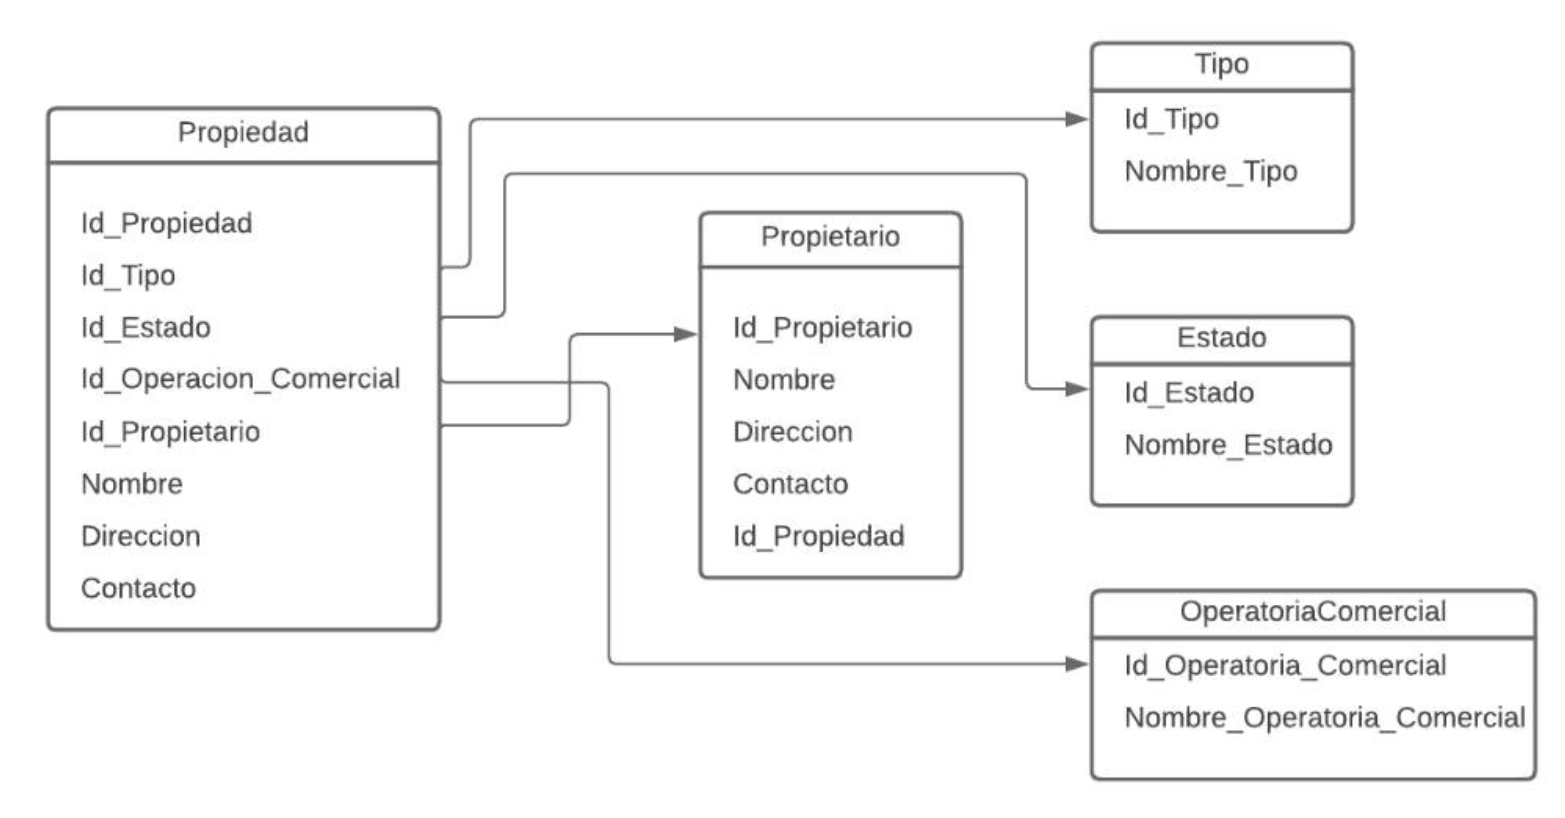

## Consulta de creación de tabla

In [11]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tablas = cursor.fetchall()
print("Tablas en la base de datos:")
for tabla in tablas:
    print(tabla[0])

Tablas en la base de datos:
Propiedad
Tipo
Propietario
Estado
OperatoriaComercial


# Funcionalidades CRUD

Se desarrollaron funciones específicas para gestionar las propiedades dentro de la base de datos:

- Ingreso de datos: Permite añadir propiedades nuevas, verificando las relaciones con las tablas auxiliares (Tipo, Estado, Operatoria Comercial y Propietario).
- Eliminación de datos: Se diseñó una función para eliminar propiedades de forma específica, manteniendo la integridad de la base de datos.
- Consultas: Funciones que permiten realizar los reportes solicitados, como el listado total de propiedades o aquellas disponibles para venta o alquiler.


Vamos a dispones de la funcionalidad de prueba y error que nos otorga Python (Try/Except) y IntegrityError de SQLite para evitar ingreso de datos erroneamente y generamos la función para agregar datos a la tambla

In [13]:
def agregar_propiedad(Id_Propiedad, id_tipo, id_estado, id_operatoria_comercial, id_propietario, nombre, direccion, contacto):
    try:
        # Definir el tipo de propiedad según id_tipo(Casa 1, Departamento 2)
        if id_tipo == 1:
            nombre_tipo = "Casa"
        elif id_tipo == 2:
            nombre_tipo = "Departamento"
        else:
            nombre_tipo = "Tipo desconocido"
        
        # Definir el estado según id_estado(1 Disponible para la venta, 2 Vendida, 3 Disponible para alquiler, 4 Alquilada)
        if id_estado == 1:
            nombre_estado = "Disponible para venta"
        elif id_estado == 2:
            nombre_estado = "Vendida"
        elif id_estado == 3:
            nombre_estado = "Disponible para alquiler"
        elif id_estado == 4:
            nombre_estado = "Alquilada"
        else:
            nombre_estado = "Estado desconocido"

        # Definir la operatoria comercial según id_operatoria_comercial (1 Venta, 2 Alquiler)
        if id_operatoria_comercial == 1:
            nombre_operatoria = "Venta"
        elif id_operatoria_comercial == 2:
            nombre_operatoria = "Alquiler"
        else:
            nombre_operatoria = "Operación desconocida"

        # Define el nombre y otros datos del propietario, si se desconocen dejar en blanco y se rellena con valores estándares.
        if not nombre:
            nombre = "Nombre desconocido"
        if not direccion:
            direccion = "Dirección desconocida"
        if not contacto:
            contacto = "Contacto desconocido"

        # Verificar si el tipo de propiedad ya existe en la tabla "Tipo", de no ser así se agrega
        cursor.execute('''INSERT OR IGNORE INTO Tipo (Id_Tipo, Nombre_Tipo) 
                          VALUES (?, ?)''', (id_tipo, nombre_tipo))
                          
        # Verificar si el estado ya existe en la tabla "Estado", de no ser así se agrega
        cursor.execute('''INSERT OR IGNORE INTO Estado (Id_Estado, Nombre_Estado) 
                          VALUES (?, ?)''', (id_estado, nombre_estado))

        # Verificar si la operatoria comercial ya existe en la tabla "OperatoriaComercial", de no ser así se agrega
        cursor.execute('''INSERT OR IGNORE INTO OperatoriaComercial (Id_Operatoria_Comercial, Nombre_Operatoria_Comercial) 
                          VALUES (?, ?)''', (id_operatoria_comercial, nombre_operatoria))

        # Verificar si el propietario ya existe en la tabla "Propietario", de no ser así se agrega
        cursor.execute('''INSERT OR IGNORE INTO Propietario (Id_Propietario, Nombre, Direccion, Contacto) 
                          VALUES (?, ?, ?, ?)''', (id_propietario, nombre, direccion, contacto))
        
        # Finalmente, ingresar la propiedad en la tabla "Propiedad" que es la principal.
        cursor.execute('''INSERT OR IGNORE INTO Propiedad 
                        (Id_Propiedad, Id_Tipo, Id_Estado, Id_Operatoria_Comercial, Ip_Propietario, Nombre, Dirección, Contacto) 
                        VALUES (?, ?, ?, ?, ?, ?, ?, ?)''', 
                       (Id_Propiedad, id_tipo, id_estado, id_operatoria_comercial, id_propietario, nombre, direccion, contacto))
        
        conexion.commit()  # Guardar los cambios en la base de datos
        print("Propiedad agregada exitosamente y relaciones verificadas.")
        
    except sqlite3.IntegrityError as e:
        print(f"Error al agregar la propiedad: {e}")


# Agregado de propiedades

Para agregar una propiedad y integrar todos los datos en todas las tablas necesitamos usa la función "agregar_propiedad"
Y especificar los datos: 
- Id de la propiedad
- Id del tipo de propiedad (1 si es una casa, 2 si es un depto),
- Id del estado de la propiedad (1 disponible para la venta, 2 vendida, 3 disponible para alquiler, 4 alquilada),
- Id de la operatoria comercial (1 venta, 2 alquiler)
- Id del propietario
- Nombre del propietario
- Dirección
- Contacto (Ya sea teléfono o dirección de mail) 

# Vamos a generar también una herramienta para realizar consultas de las distintas tablas creadas en la base de datos.

### Así podemos tenes noción del estado de cada propiedad, su disponibilidad y su situación comercial

In [15]:
def ConsultaTabla(Tabla):
    try:
        # Crear la consulta SQL con el nombre de la tabla pasado como parámetro
        cursor.execute(f"SELECT * FROM {Tabla};")  # Usamos f-string para generar la consulta dinámicamente
        registros = cursor.fetchall()  # Obtener todos los registros

        # Mostrar los registros obtenidos
        print(f"Registros en la tabla '{Tabla}':")
        for registro in registros:
            print(registro)
            
    except sqlite3.OperationalError as e:
        print(f"Error al consultar la tabla '{Tabla}': {e}")

# Creamos la función para eliminar cualquier dato en específico

In [17]:
def EliminarRegistro(Tabla, columna, valor):
    try:
        # Ejecutamos la consulta SQL para eliminar los datos específicos
        cursor.execute(f"DELETE FROM {Tabla} WHERE {columna} = ?", (valor,))
        conexion.commit()  # Guardamos los cambios en la base de datos

        print(f"Registro con {columna} = {valor} eliminado de la tabla {Tabla}.")
        
    except sqlite3.OperationalError as e:# Se aclaran los posibles errores en consola
        print(f"Error al intentar eliminar en la tabla '{Tabla}': {e}")
    except sqlite3.IntegrityError as e:
        print(f"Error de integridad al intentar eliminar: {e}")

# Función para consultar lista de propiedad Totales

In [22]:
def listar_propiedades_totales():
    try:
        cursor.execute('''SELECT * FROM Propiedad''')
        propiedades = cursor.fetchall()
        
        if propiedades:
            print("Listado de propiedades TOTALES:")
            for propiedad in propiedades:
                print(propiedad)
        else:
            print("No hay propiedades registradas.")
            
    except sqlite3.Error as e:
        print(f"Error al listar propiedades: {e}")


# Función para consultar lista de propiedad DISPONIBLES para la venta:

In [27]:
def listar_propiedades_disponibles_venta():
    try:
        cursor.execute('''SELECT * FROM Propiedad 
                          WHERE Id_Estado = 1 AND Id_Operatoria_Comercial = 1''')
        propiedades = cursor.fetchall()
        
        if propiedades:
            print("Listado de propiedades DISPONIBLES para la venta:")
            for propiedad in propiedades:
                print(propiedad)
        else:
            print("No hay propiedades disponibles para la venta.")
            
    except sqlite3.Error as e:
        print(f"Error al listar propiedades: {e}")


# Función para consultar lista de propiedad DISPONIBLES para alquiler:

In [32]:
def listar_propiedades_disponibles_alquiler():
    try:
        cursor.execute('''SELECT * FROM Propiedad 
                          WHERE Id_Estado = 1 AND Id_Operatoria_Comercial = 2''')
        propiedades = cursor.fetchall()
        
        if propiedades:
            print("Listado de propiedades DISPONIBLES para alquiler:")
            for propiedad in propiedades:
                print(propiedad)
        else:
            print("No hay propiedades disponibles para alquiler.")
            
    except sqlite3.Error as e:
        print(f"Error al listar propiedades: {e}")


# Función para consultar listado de propiedades VENDIDAS:

In [38]:
def listar_propiedades_vendidas():
    try:
        cursor.execute('''SELECT * FROM Propiedad 
                          WHERE Id_Estado = 2''')
        propiedades = cursor.fetchall()
        
        if propiedades:
            print("Listado de propiedades VENDIDAS:")
            for propiedad in propiedades:
                print(propiedad)
        else:
            print("No hay propiedades vendidas.")
            
    except sqlite3.Error as e:
        print(f"Error al listar propiedades: {e}")


#  Función para consultar listado de propiedades ALQUILADAS:

In [44]:
def listar_propiedades_alquiladas():
    try:
        cursor.execute('''SELECT * FROM Propiedad 
                          WHERE Id_Estado = 3''')
        propiedades = cursor.fetchall()
        
        if propiedades:
            print("Listado de propiedades ALQUILADAS:")
            for propiedad in propiedades:
                print(propiedad)
        else:
            print("No hay propiedades alquiladas.")
            
    except sqlite3.Error as e:
        print(f"Error al listar propiedades: {e}")

# Cierre de sesión 

Al finalizar y para asegurar que todo quede guardado, cerramos la sesión 

In [71]:
conexion.commit()  # Guardar los cambios
cursor.close()  # Cerrar el cursor
conexion.close()  # Cerrar la conexión

# Conclusión

Este proyecto ha permitido crear una solución eficaz para la gestión de propiedades inmobiliarias mediante un sistema CRUD que integra Python con SQLite. Se ha proporcionado una estructura sólida y flexible que permite a la inmobiliaria almacenar, actualizar y consultar datos de manera sencilla y eficiente, garantizando la persistencia y fiabilidad de la información.